In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, confusion_matrix, log_loss, cohen_kappa_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
import joblib
import time
import pandas as pd

In [17]:
# Load models
xgb = joblib.load('models/xgb_model.pkl')
cat = joblib.load('models/cb_model.pkl')
lgb = joblib.load('models/lbgm_model.pkl')
rf = joblib.load('models/rf_model.pkl')
dt = joblib.load('models/dt_model.pkl')

for i in [xgb, lgb]:
    params = i.get_params()
    params["early_stopping_rounds"] = None
    i.set_params(**params)

In [18]:
# Load data
train_df = pd.read_csv('datasets/train.csv', index_col=0)
test_df = pd.read_csv('datasets/test.csv', index_col=0)

X_train = train_df.drop(columns=['EVENT']) # Features
y_train = train_df['EVENT'] # Labels
X_test = test_df.drop(columns=['EVENT'])
y_test = test_df['EVENT']

In [19]:
# Build stacking ensemble
start_time = time.time()
stack = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgb', lgb),
        ('rf', rf),
        ('dt', dt)
    ],
    final_estimator=LogisticRegression(), cv=5
)

In [ ]:
# Train model and make predictions
stack.fit(X_train, y_train)

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

start_time = time.time()
y_pred = stack.predict_proba(X_test)[:, 1]
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Inference time: {training_time:.4f} seconds")
auc = roc_auc_score(y_test, y_pred)
print("Stacked model ROC AUC:", auc)

0:	total: 201ms	remaining: 3m 21s
100:	total: 15.3s	remaining: 2m 16s
200:	total: 45.7s	remaining: 3m 1s
300:	total: 1m 19s	remaining: 3m 4s
400:	total: 1m 35s	remaining: 2m 23s
500:	total: 1m 55s	remaining: 1m 54s
600:	total: 2m 21s	remaining: 1m 34s
700:	total: 2m 52s	remaining: 1m 13s
800:	total: 3m 15s	remaining: 48.5s
900:	total: 3m 28s	remaining: 23s
999:	total: 3m 43s	remaining: 0us
[LightGBM] [Info] Number of positive: 137834, number of negative: 137513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 275347, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500583 -> initscore=0.002332
[LightGBM] [Info] Start training from score 0.002332
[LightGBM] [Warning] No further splits with posit

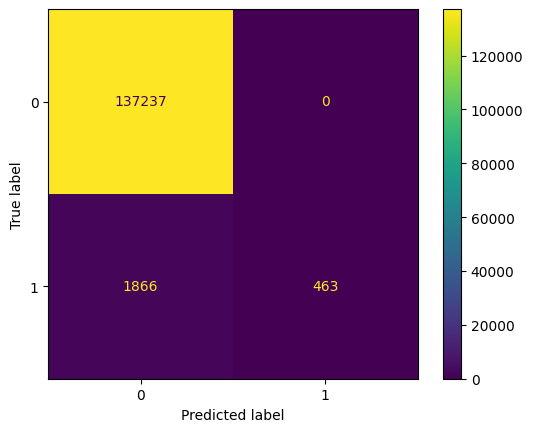

In [23]:
# Confusion matrix
y_pred1 = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [24]:
# Other metrics
#y_pred_proba = stack.predict_proba(X_test)[:, 1] # Probabilities for positive class only

print("Accuracy: ", accuracy_score(y_test, y_pred1))
print("Precision: ", precision_score(y_test, y_pred1))
print("Recall: ", recall_score(y_test, y_pred1))
print("F1 Score: ", f1_score(y_test, y_pred1))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred))
print("PR-AUC (Average Precision): ", average_precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1, labels=[0,1]))
print("Log Loss: ", log_loss(y_test, y_pred))
print("Cohen's Kappa: ", cohen_kappa_score(y_test, y_pred1))

Accuracy:  0.9866299815141224
Precision:  1.0
Recall:  0.19879776728209533
F1 Score:  0.3316618911174785
ROC-AUC:  0.75715368773766
PR-AUC (Average Precision):  0.4222499405648246
Confusion Matrix:
 [[137237      0]
 [  1866    463]]
Log Loss:  0.4182997131571824
Cohen's Kappa:  0.3279423276542899
